# The Neural Code: Exercises 1

In [1]:
import numpy as np
from matplotlib import pyplot as plt

__Exercise 3.(a)__

In [2]:
N = 10
lambdas = np.linspace(0.1, 1, N)
T = 100
t_all_trials = []

for i_trial in range(N):
    t_trial = [-1]
    while t_trial[-1] < T:
        u = np.random.rand()
        ISI = -np.log(1-u) / lambdas[i_trial]
        if t_trial[-1] + ISI > T:
            break
        else:
            if t_trial[-1] == -1:
                t_trial[-1] = ISI
            else:
                t_trial.append(t_trial[-1] + ISI)
    t_all_trials.append(t_trial)

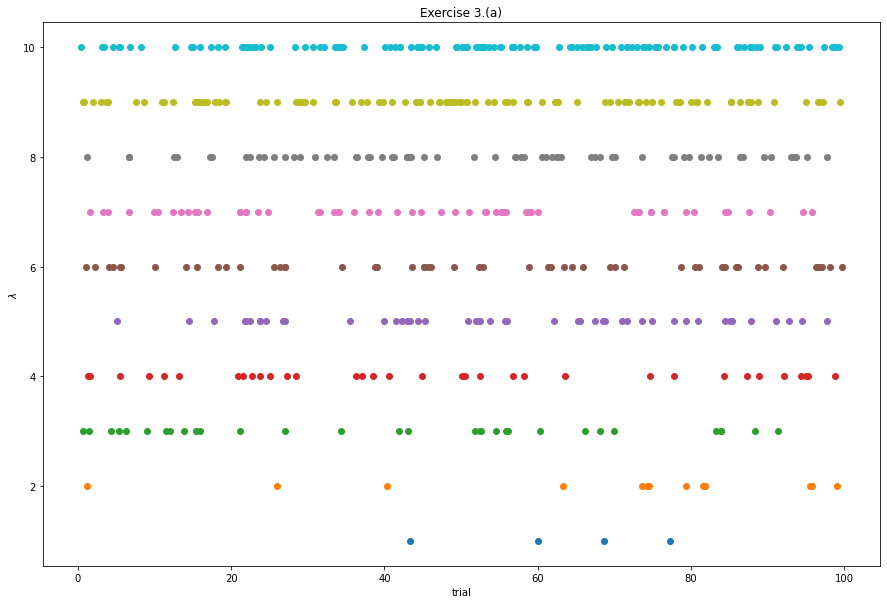

In [3]:
plt.figure(figsize = (15,10))
for i_trial in range(N):
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), i_trial + 1))
    plt.xlabel('trial')
    plt.ylabel('$\lambda$')
    plt.title('Exercise 3.(a)')

__Exercise 3.(b)__

In [4]:
def my_integral(lam, t, m, T):
    result = ((lam/2)*t) + (((lam*T)/(4*np.pi*m)) * np.sin((2*np.pi*m*t)/T))
    return result                  

In [5]:
N = 10
T = 100
t_all_trials = []
ts = 0.1

for i_trial in range(N):
    left_expression = np.nan
    m = i_trial + 1
    t_trial = [-1]
    
    while t_trial[-1] < T:
        u = np.random.rand()
        
        if np.isnan(left_expression):
            left_expression = -np.log(1-u)
        else:
            left_expression += -np.log(1-u)
            
        right_expression = 0
        
        curr_ISI = 0
        while left_expression > right_expression:
            right_expression = my_integral(1, curr_ISI, m, T)
            if left_expression > right_expression:
                curr_ISI += ts
        
        final_ISI = curr_ISI

        if t_trial[-1] + final_ISI > T:
            break
        else:
            if t_trial[-1] == -1:
                t_trial[-1] = final_ISI
            else:
                t_trial.append(t_trial[-1] + final_ISI)
    t_all_trials.append(t_trial)

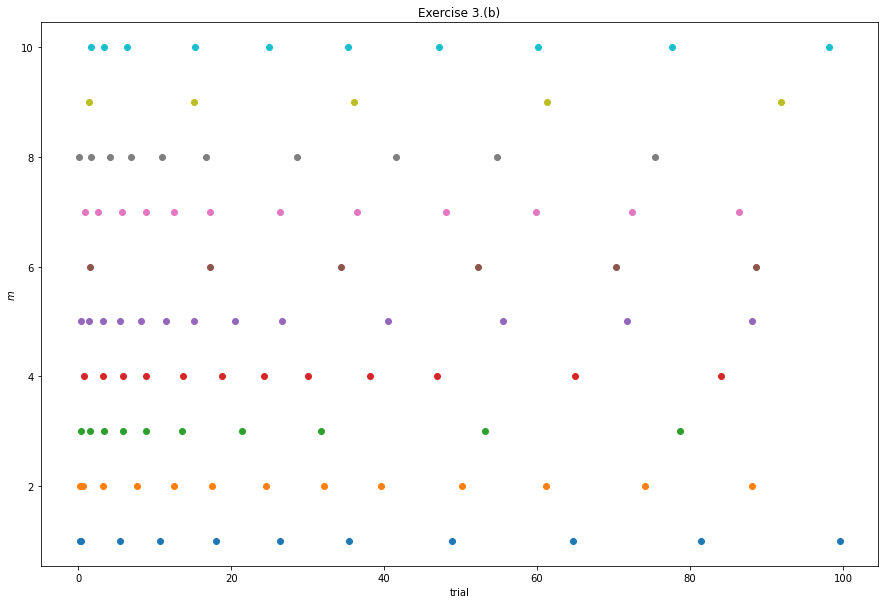

In [6]:
plt.figure(figsize = (15,10))
for i_trial in range(N):
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), i_trial + 1))
    plt.xlabel('trial')
    plt.ylabel('$m$')
    plt.title('Exercise 3.(b)')

__Exercise 3.(c)__

In [7]:
def my_tau(m):
    tau = (2 ** (m-1)) / 1000
    return tau

In [13]:
N = 5
lam = 10
T = 50
tau_m = [6, 8, 10, 12, 14]
t_all_trials = []

for i_trial in range(N):
    t_trial = [-1]
    tau = my_tau(tau_m[i_trial])
    while t_trial[-1] < T:
        u = np.random.rand()
        ISI = -np.log(1-u) / lam
        if t_trial[-1] + ISI + tau > T:
            break
        else:
            if t_trial[-1] == -1:
                t_trial[-1] = ISI + tau
            else:
                t_trial.append(t_trial[-1] + ISI + tau)
    t_all_trials.append(t_trial)

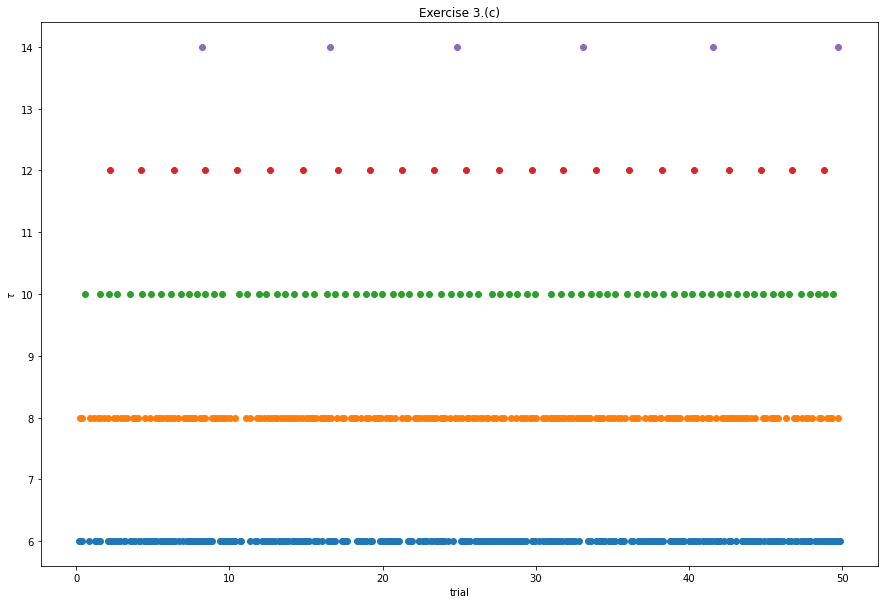

In [14]:
plt.figure(figsize = (15,10))
for i_trial in range(N):
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), tau_m[i_trial]))
    plt.xlabel('trial')
    plt.ylabel('$\\tau$')
    plt.title('Exercise 3.(c)')